In [18]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [19]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [20]:
# Save the input and target variables
# print(diabetes_dataset.keys())
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [21]:
# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean(axis=0)) / targets.std()
targets

array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [22]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [23]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    
    return model

model = get_model()

In [24]:
# Print the model summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [25]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [26]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [27]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.8590 - mae: 0.6175


[0.7315519346131218, 0.617482]

#### Plot the learning curves

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

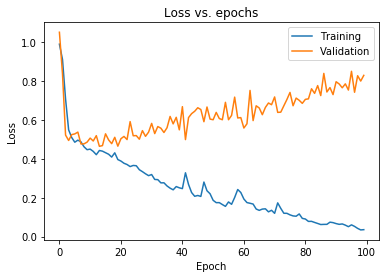

In [29]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [30]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [31]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, activation="relu"),
        Dense(1)
    ])
    return model

In [32]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)


In [34]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [37]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)


In [38]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)


45/1 - 0s - loss: 0.6399 - mae: 0.5903


[0.6013374434577095, 0.59031063]

#### Plot the learning curves

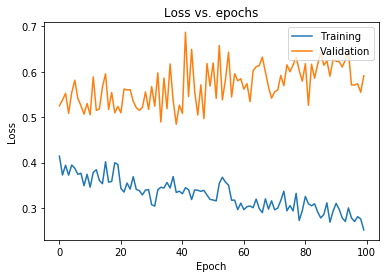

In [39]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [40]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    def on_train_begin(self, logs=None):
        print('Starting training...')
    def on_epoch_begin(self, epoch, logs=None):
        print(f'Training: Starting epoch {epoch}')
    def on_train_batch_begin(self, batch, logs=None):
        print(f'Training: Starting batch {batch}')
    def on_train_batch_end(self, batch, logs=None):
        print(f'Training: Finished batch {batch}')
    def on_epoch_end(self, epoch, logs=None):
        print(f'Training: Finished epoch {epoch}')
    def on_train_end(self, logs=None):
        print('Finished training...')


In [47]:
from tensorflow.keras.callbacks import Callback

class TestingCallback(Callback):
    def on_test_begin(self, logs=None):
        print('Starting testing...')
    def on_test_batch_begin(self, batch, logs=None):
        print(f'Training: Starting batch {batch}')
    def on_test_batch_end(self, batch, logs=None):
        print(f'Training: Finished batch {batch}')
    def on_test_end(self, logs=None):
        print('Finished testing...')


In [50]:
from tensorflow.keras.callbacks import Callback

class PredictingCallback(Callback):
    def on_predict_begin(self, logs=None):
        print('Starting prediction...')
    def on_predict_batch_begin(self, batch, logs=None):
        print(f'Prediction: Starting batch {batch}')
    def on_predict_batch_end(self, batch, logs=None):
        print(f'Prediction: Finished batch {batch}')
    def on_predict_end(self, logs=None):
        print('Finished predicting...')


In [42]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)


In [45]:
# Compile the model
model.compile(optimizer='adam', loss='mse')


#### Train the model with the callback

In [46]:
# Train the model, with some of the data reserved for validation
model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False,callbacks=[TrainingCallback()])


Starting training...
Training: Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Training: Finished epoch 0
Training: Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Training: Finished epoch 1
Training: Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Training: Finished epoch 2
Finished training...


In [49]:
# Evaluate the model

model.evaluate(test_data, test_targets, callbacks=[TestingCallback()], verbose=False)

Starting testing...
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1


0.832235418425666

In [51]:
# Make predictions with the model
model.predict(test_data, verbose=False, callbacks=[PredictingCallback()])


Starting prediction...
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1
Finished predicting...


array([[-0.00257471],
       [-0.16119853],
       [-0.10601203],
       [-0.13474508],
       [-0.13659304],
       [-0.01788248],
       [-0.04446095],
       [-0.12245695],
       [-0.04546408],
       [-0.12523043],
       [-0.04555804],
       [-0.10043183],
       [-0.12244596],
       [-0.1578903 ],
       [-0.02775045],
       [-0.14409027],
       [-0.05406226],
       [-0.11815769],
       [-0.02049067],
       [-0.13670556],
       [-0.0983362 ],
       [-0.02151528],
       [ 0.00494664],
       [-0.1166537 ],
       [-0.15479128],
       [-0.16053078],
       [-0.03785807],
       [-0.11493353],
       [-0.10739342],
       [-0.12298794],
       [-0.12060235],
       [-0.13212979],
       [-0.01368658],
       [ 0.00791438],
       [-0.11020522],
       [ 0.00529806],
       [-0.04188157],
       [-0.07647855],
       [-0.0880782 ],
       [-0.06940011],
       [-0.06871967],
       [-0.01848885],
       [-0.00393827],
       [-0.00486774],
       [-0.03627611]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [73]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mse')
unreg_history = model.fit(train_data, train_targets,
                          validation_split=0.15, 
                          epochs=100, 
                          batch_size=64, 
                          verbose=False, 
                          callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [74]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.8860


0.8883214129341973

In [75]:
# Re-train the regularised model
reg_model = get_regularised_model(1e-8, 0.2)
reg_model.compile(optimizer='adam', loss='mse')
reg_history = reg_model.fit(train_data, train_targets,
                               validation_split=0.15, 
                               epochs=100, 
                               batch_size=64, 
                               verbose=False, 
                               callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [76]:
# Evaluate the model on the test set
reg_model.evaluate(test_data, test_targets, verbose=2)


45/1 - 0s - loss: 0.4340


0.4494350830713908

#### Plot the learning curves

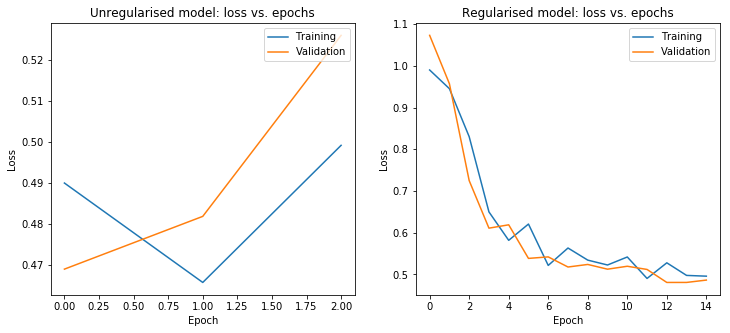

In [77]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()